# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt


from dataloader.load_regression_data_from_arbitrary_gp import RegressionDataGeneratorArbitraryGP, draw_single_example_from_arbitrary_gp
from model import ConditionalNeuralProcess
from utils.plot import plot_learning_curve
from utils.gaussian_processes.gp_model import plot_mean_with_std
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test, plot_preds_from_single_example

2023-03-11 21:36:12.345850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 21:36:13.525025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 21:36:13.525057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 21:36:13.654980: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-11 21:36:16.536980: W tensorflow/stream_executor/pla

# DataGenerator

In [2]:
KERNEL_LENGTH_SCALE = 0.4

data_generator = RegressionDataGeneratorArbitraryGP(
    iterations=25,
    batch_size=32,
    min_num_context=3,
    max_num_context=40,
    min_num_target=2,
    max_num_target=40,
    min_x_val_uniform=-2,
    max_x_val_uniform=2,
    kernel_length_scale=KERNEL_LENGTH_SCALE
)

2023-03-11 21:36:21.923996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-11 21:36:21.924787: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 21:36:21.924844: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-03-11 21:36:21.931528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(context_x, context_y, target_x), target_y = next(iter(data_generator.train_ds))

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

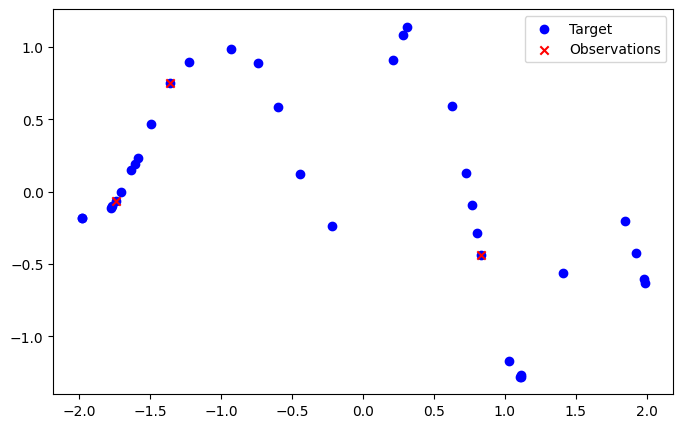

In [4]:
data_generator.plot_first_elt_of_random_batch()

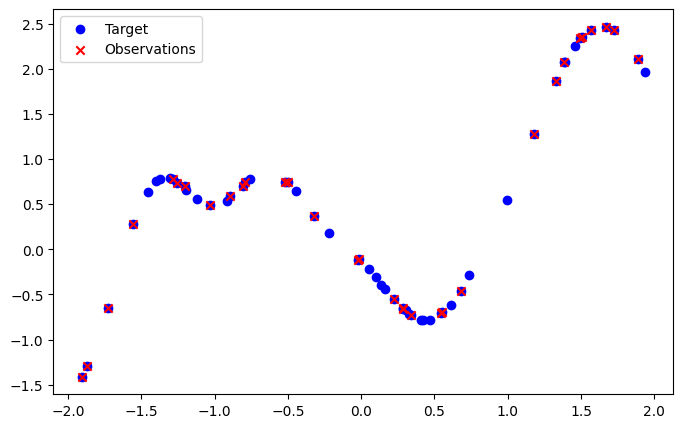

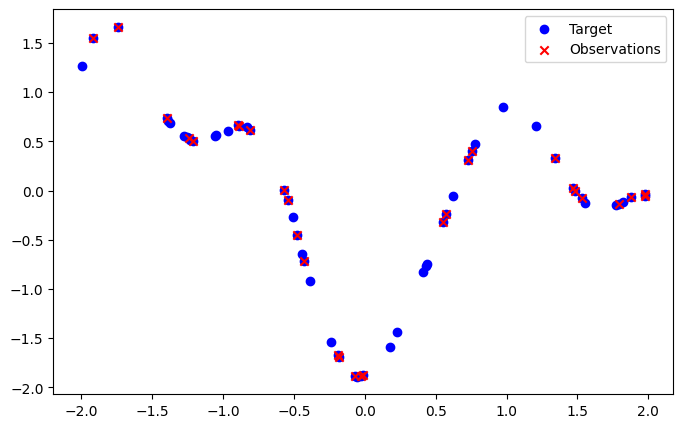

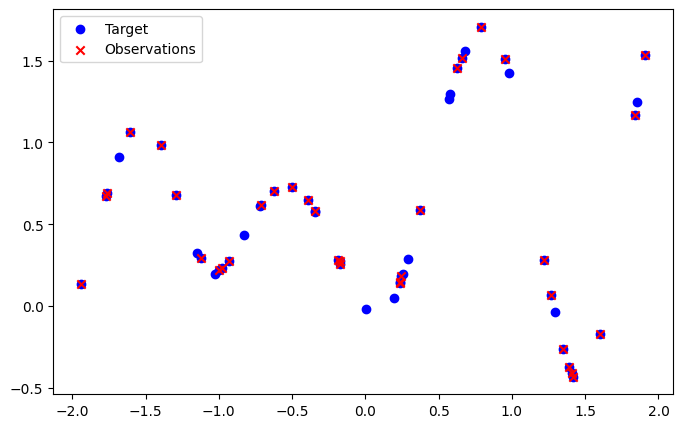

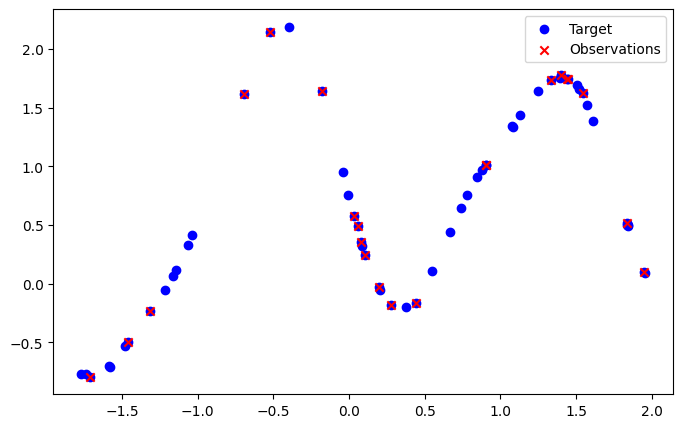

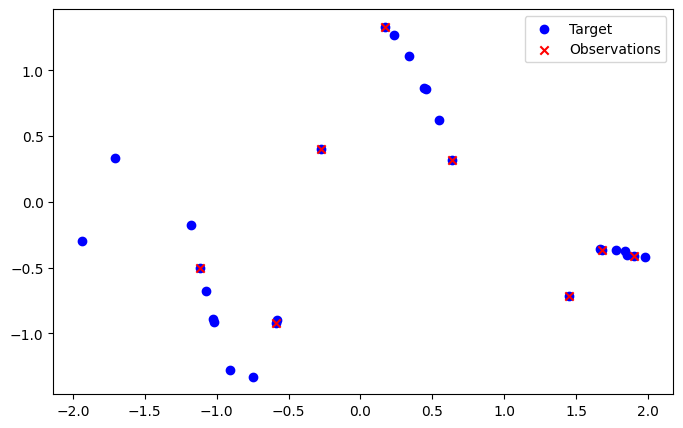

In [5]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGeneratorArbitraryGP.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

# Train CNP

In [6]:
encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [7]:
callbacks = []

log_dir = f'logs/cnp/regression/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5)

callbacks.append(tensorboard_callback)

callbacks.append(
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        monitor="val_loss",
        mode="min",
        restore_best_weights=True)
    )

In [8]:
history = model.fit(data_generator.train_ds,
                    validation_data=data_generator.test_ds,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
      4/Unknown - 4s 661ms/step - loss: 1.4510WARNING:tensorflow:5 out of the last 5 calls to <function ConditionalNeuralProcess.call at 0x7fc0883c5990> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
      5/Unknown - 4s 639ms/step - loss: 1.4385WARNING:tensorflow:6 out of the last 6 calls to <function ConditionalNeuralProcess.call at 0x7fc0883c5990> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creat

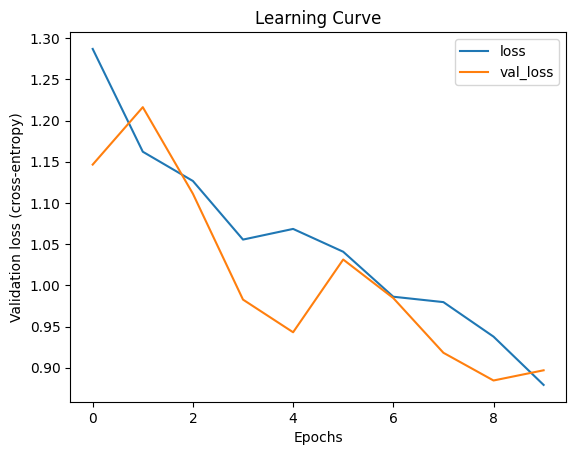

In [9]:
plot_learning_curve(history)

# Plot

## Plot a few examples from test set

1/1 [==============================] - 0s 74ms/step


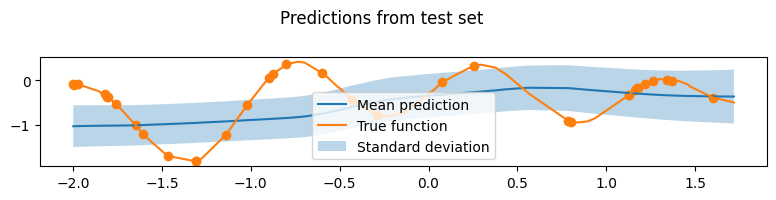

In [10]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 71ms/step


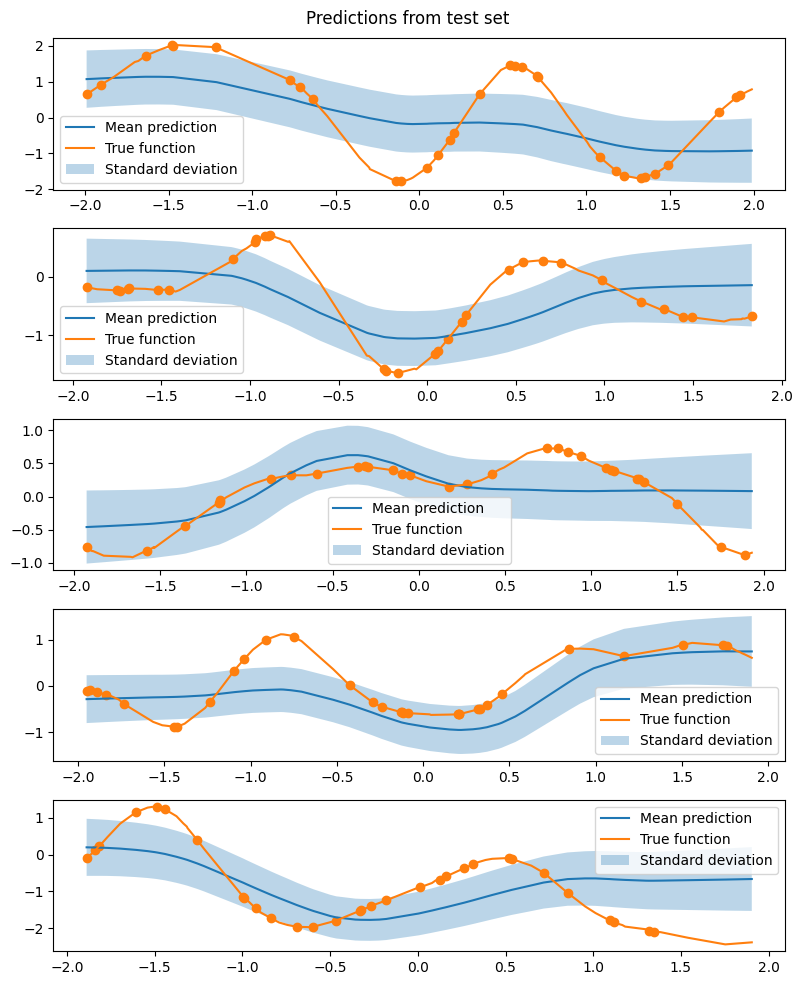

In [11]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)

## Plot for different numbers of context points

1/1 [==============================] - 0s 255ms/step


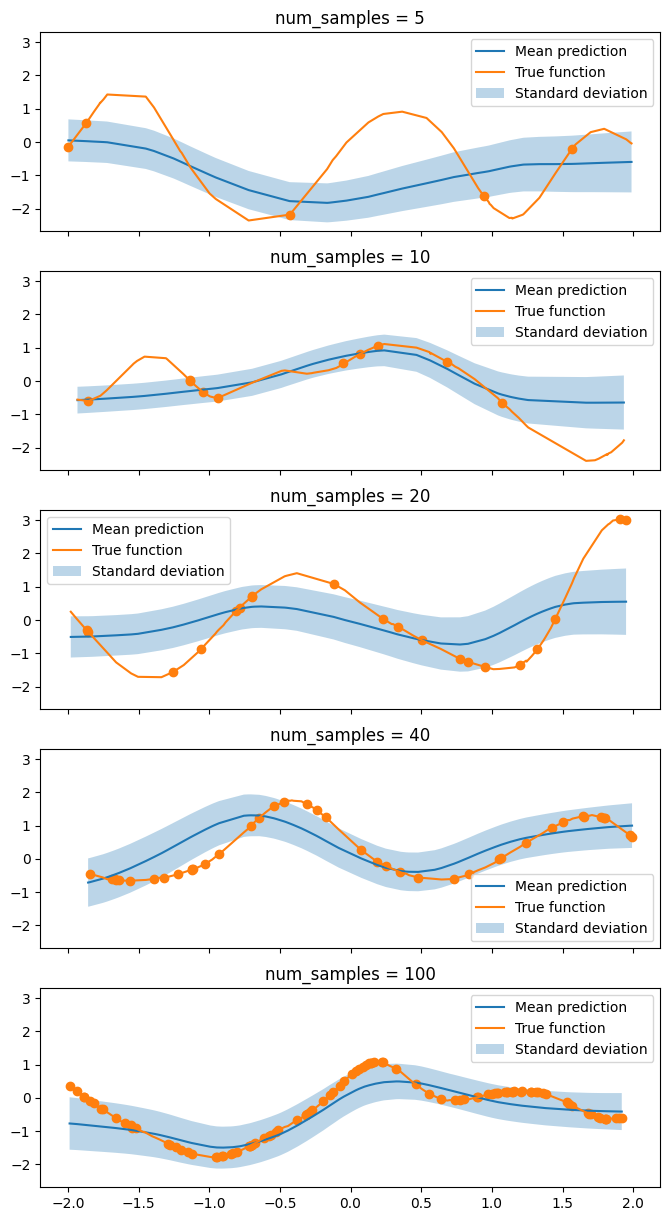

In [12]:
list_num_context = [5, 10, 20, 40, 100]

fig, axis = plt.subplots(len(list_num_context), 1,
                         figsize=(8, 3*len(list_num_context)),
                         sharex=True,
                         sharey=True)

for idx_plot, num_context in enumerate(list_num_context):
    (context_x, context_y, target_x), target_y = draw_single_example_from_arbitrary_gp(
        kernel_length_scale=KERNEL_LENGTH_SCALE,
        num_context=num_context,
        num_target=50
    )
    
    plot_preds_from_single_example(model, context_x, context_y, target_x, target_y, ax=axis[idx_plot])

## Plot for different numbers of context points against the true GP

1/1 [==============================] - 0s 34ms/step


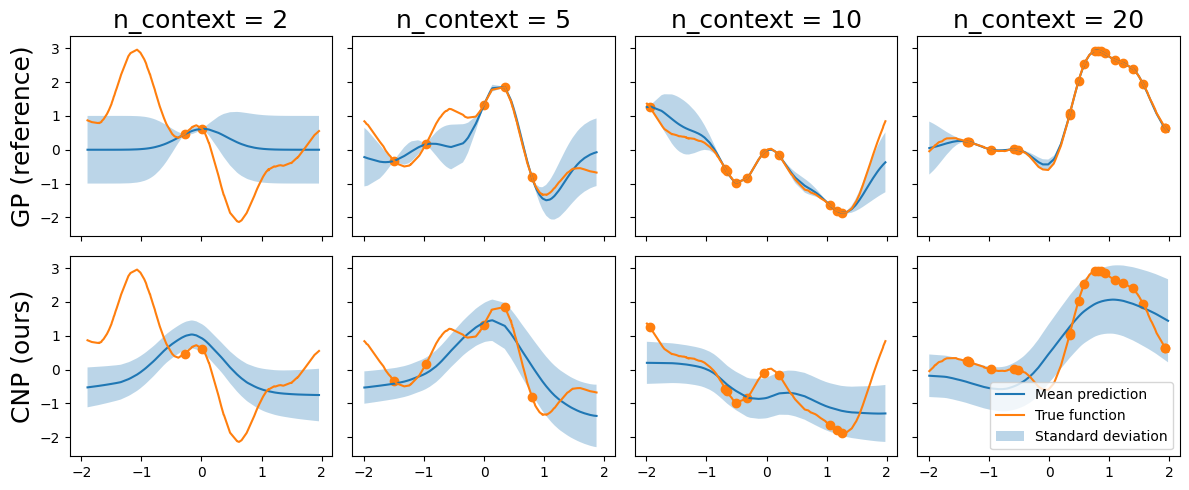

In [20]:
list_num_context = [2, 5, 10, 20]
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=KERNEL_LENGTH_SCALE)


fig, axis = plt.subplots(2, len(list_num_context),
                         figsize=(3*len(list_num_context), 5),
                         sharex=True,
                         sharey=True)


for idx_plot, num_context in enumerate(list_num_context):
    # --- CNP ---
    (context_x, context_y, target_x), target_y = draw_single_example_from_arbitrary_gp(
        kernel_length_scale=KERNEL_LENGTH_SCALE,
        num_context=num_context,
        num_target=100
    )
    
    plot_preds_from_single_example(model, context_x, context_y, target_x, target_y,
                                   show_title=False, ax=axis[1, idx_plot])

    
    # --- GP ---
    gp = tfd.GaussianProcessRegressionModel(
                kernel=kernel,
                index_points=target_x,
                observation_index_points=context_x,
                observations=tf.squeeze(context_y),
                jitter=1.0e-4
    )

    context_x = tf.squeeze(context_x)
    target_x = tf.squeeze(target_x)
    gp_mean_predict = gp.mean()
    gp_std_predict = gp.stddev()
    
    idx_x_sorted = tf.argsort(target_x)
    
    target_x = tf.gather(target_x, idx_x_sorted)
    target_y = tf.gather(target_y, idx_x_sorted)
    gp_mean_predict = tf.gather(gp_mean_predict, idx_x_sorted)
    gp_std_predict = tf.gather(gp_std_predict, idx_x_sorted)

    plot_mean_with_std(x=target_x.numpy(),
                       mean=gp_mean_predict.numpy(),
                       std=gp_std_predict.numpy(),
                       y_true=target_y.numpy(),
                       ax=axis[0, idx_plot]
    )
    
    axis[0, idx_plot].scatter(context_x.numpy(), context_y.numpy())


for ax, label in zip(axis[0, :], [f"n_context = {n}" for n in list_num_context]):
    ax.set_title(label, size=18)

for ax in axis.flatten()[:-1]:
    ax.get_legend().remove()
    
axis[0, 0].set_ylabel("GP (reference)", size=18)
axis[1, 0].set_ylabel("CNP (ours)", size=18)

    
fig.tight_layout()